# Comparing two models by the worst-case risk

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.auto import tqdm

In [161]:
url = 'https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv'
r = requests.get(url)
with open('AirPassengers.csv', 'wb') as f:
    f.write(r.content)
ts_data = pd.read_csv('AirPassengers.csv', index_col=0)['#Passengers']
ts_data.name = 'target'
ts_data.index = pd.to_datetime(ts_data.index)
ts_data.index.name = 'date'
ts_data= np.log(ts_data)
ts_data = ts_data.asfreq('MS')
ts_data

date
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
                ...   
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426
Freq: MS, Name: target, Length: 144, dtype: float64

In [162]:
month = pd.get_dummies(ts_data.index.month, prefix='m', dtype=int)
month.index = ts_data.index
month

,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
date,,,,,,,,,,,,
1949-01-01,1,0,0,0,0,0,0,0,0,0,0,0
1949-02-01,0,1,0,0,0,0,0,0,0,0,0,0
1949-03-01,0,0,1,0,0,0,0,0,0,0,0,0
1949-04-01,0,0,0,1,0,0,0,0,0,0,0,0
1949-05-01,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1960-08-01,0,0,0,0,0,0,0,1,0,0,0,0
1960-09-01,0,0,0,0,0,0,0,0,1,0,0,0
1960-10-01,0,0,0,0,0,0,0,0,0,1,0,0


In [187]:
horizon = 6
input_size = 24

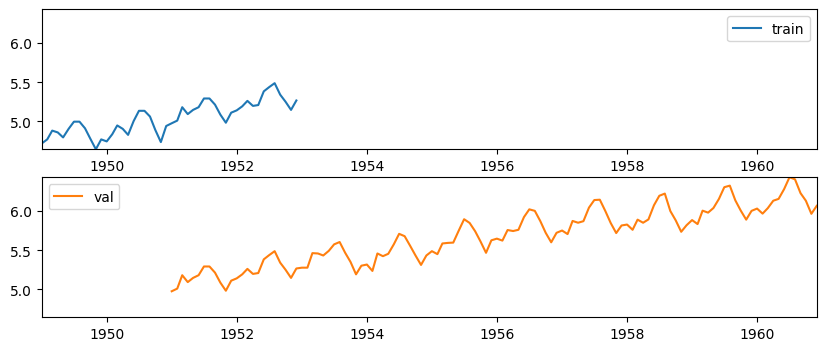

In [266]:
split = 48
target_train = ts_data[:split]
target_val = ts_data[split-input_size:]
exog_train = month[:split]
exog_val = month[split-input_size:]

plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.plot(target_train, label='train')
plt.xlim(ts_data.index[0], ts_data.index[-1])
plt.ylim(ts_data.min(), ts_data.max())
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(target_val, label='val', c='tab:orange')
plt.xlim(ts_data.index[0], ts_data.index[-1])
plt.ylim(ts_data.min(), ts_data.max())
plt.legend()
plt.show()

In [267]:
class SARIMA():
    def __init__(self, p, i, q, P, I, Q, s):
        self.p = p
        self.i = i
        self.q = q
        self.P = P
        self.I = I
        self.Q = Q
        self.s = s
    def fit(self, target, exog=None):
        model = SARIMAX(
            target, exog, 
            order=(self.p, self.i, self.q),
            seasonal_order=(self.P, self.I, self.Q, self.s),
        )
        self.res = model.fit(disp=False, maxiter=500)
    def predict(self, horizon, past_target, past_exog=None, future_exog=None):
        res = self.res.apply(endog=past_target, exog=past_exog)
        pred = res.forecast(steps=horizon, exog=future_exog)
        return pred
    def backtest(self, input_size, horizon, target, exog):
        abs_error = []
        for i in range(len(target)-input_size-horizon+1):
            past_range = range(i, i+input_size)
            future_range = range(i+input_size, i+input_size+horizon)
            past_target = target.iloc[past_range]
            future_target = target.iloc[future_range]
            past_exog = exog.iloc[past_range]
            future_exog = exog.iloc[future_range]
            future_pred = self.predict(horizon, past_target, past_exog, future_exog)
            abs_error.append(np.abs(future_pred - future_target))
        return pd.Series(np.array(abs_error).mean(axis=1), index=target.index[input_size+horizon-1:])

In [318]:
model0 = SARIMA(p=1, i=1, q=0, P=0, I=0, Q=0, s=0)
model0.fit(
    target_train, 
    exog_train,
)
pred = model0.predict(
    len(target_val)-input_size, 
    target_val.iloc[:input_size], 
    exog_val.iloc[:input_size],
    exog_val.iloc[input_size:],
)

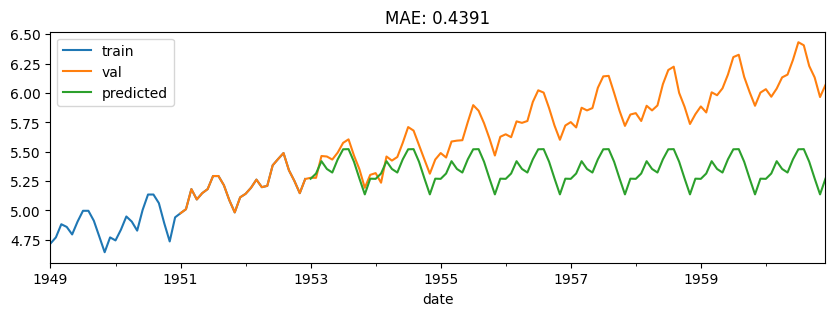

In [319]:
mae = np.abs(pred - target_val.iloc[input_size:]).mean()
plt.figure(figsize=(10, 3))
target_train.plot(label='train')
target_val.plot(label='val')
pred.plot(label='predicted')
plt.legend()
plt.title(f'MAE: {mae:.4f}')
plt.show();

In [345]:
model1 = SARIMA(p=1, i=1, q=0, P=1, I=1, Q=0, s=12)
model1.fit(
    target_train, 
    exog_train,
)
pred = model1.predict(
    len(target_val)-input_size, 
    target_val.iloc[:input_size], 
    exog_val.iloc[:input_size],
    exog_val.iloc[input_size:],
)

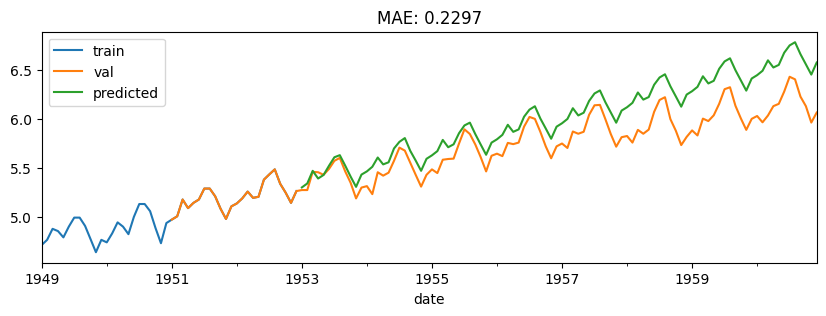

In [346]:
mae = np.abs(pred - target_val.iloc[input_size:]).mean()
plt.figure(figsize=(10, 3))
target_train.plot(label='train')
target_val.plot(label='val')
pred.plot(label='predicted')
plt.legend()
plt.title(f'MAE: {mae:.4f}')
plt.show();

In [347]:
error0 = model0.backtest(input_size, horizon, target_val, exog_val)
error0.mean()

0.07011093592272447

In [348]:
error1 = model1.backtest(input_size, horizon, target_val, exog_val)
error1.mean()

0.039508640818759856

In [349]:
X_val = pd.DataFrame(target_val)
for i in range(1, input_size):
    X_val[f'target_{i}'] = X_val['target'].shift(i)
X_val = pd.concat([X_val, exog_val], axis=1).dropna()
X_val = X_val[:-horizon]
X_val.shape

(91, 36)

In [350]:
from genrisk.shift import ConditionalShift

In [351]:
mutable_columns = X_val.columns[:input_size].tolist()
immutable_columns = X_val.columns[input_size:].tolist()

In [352]:
alpha_space = np.linspace(0.05, 0.95, 10)
alpha_space

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [353]:
risk0 = []
risk1 = []
for alpha in tqdm(alpha_space):
    shift_model = ConditionalShift(mutable_columns, immutable_columns, alpha=alpha, cv=5)
    shift_model.fit(X_val, error0)
    risk0.append([shift_model.risk, shift_model.lb_risk, shift_model.ub_risk])
    shift_model.fit(X_val, error1)
    risk1.append([shift_model.risk, shift_model.lb_risk, shift_model.ub_risk])
risk0 = np.array(risk0)
risk1 = np.array(risk1)

  0%|          | 0/10 [00:00<?, ?it/s]

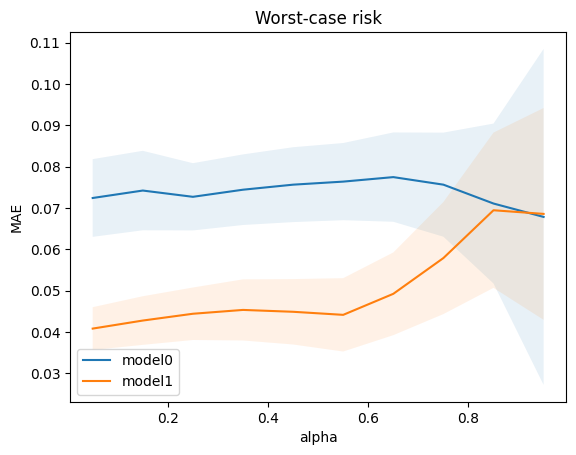

In [356]:
plt.plot(alpha_space, risk0[:, 0], label='model0')
plt.fill_between(alpha_space, risk0[:, 1], risk0[:, 2], alpha=0.1)
plt.plot(alpha_space, risk1[:, 0], label='model1')
plt.fill_between(alpha_space, risk1[:, 1], risk1[:, 2], alpha=0.1)
plt.legend(loc='lower left')
plt.title('Worst-case risk')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.show()